In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import os
import cv2 as cv
import wget
import uuid
import matplotlib.pyplot as plt


### Set GPU Growth

In [36]:
gpus = tf.config.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [37]:
gpus

[]

### Create Folder Structure

In [9]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH  = os.path.join('data','anchor')

In [15]:
POS_PATH

'data\\positive'

In [10]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

### Collect Positives And Anchors

- Untar Labelled Face In The Wild Dataset

In [21]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
lfw = wget.download(url)

In [22]:
!tar -xf lfw.tgz

In [23]:
# move LFW image to the following repository data/nagative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

- Collect Positive and Anchor Class

In [27]:
# establish a connection to the webcam

cap = cv.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()

  # cut down frame to 250x250px

  frame = frame[120:120+250,200:200+250,:]

  #collect anchor

  if cv.waitKey(1) & 0XFF == ord('a'):
    # create the unique file path
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    # write out anchor image
    cv.imwrite(imgname, frame)
    pass

  # collect positive

  if cv.waitKey(1) & 0XFF == ord('p'):
    # create the unique file path
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    # write out anchor image
    cv.imwrite(imgname, frame)
    pass

  cv.imshow("Image Collection", frame)

  if cv.waitKey(1) & 0XFF == ord('q'):
    break

cap.release()
cv.destroyAllWindows()

KeyboardInterrupt: 

### Load And Process Image

- Get image from direcotry

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(300)


In [8]:
dir_test = anchor.as_numpy_iterator()


In [11]:
print(dir_test.next())

b'data\\anchor\\cc09f689-0af5-11ef-9ab2-709cd184847d.jpg'


- Proceesing and Scale-Resize Image

In [6]:
def preprocess(file_path):

    # read in image from file path
    byte_image = tf.io.read_file(file_path)

    #load in the image
    img = tf.io.decode_jpeg(byte_image)

    # preprocessing step - resizing the image to the 100x100x3
    img = tf.image.resize(img, (100,100))

    #scale the image to be between 0 and 1

    img = img/255.0
    

    return img

In [8]:
img = preprocess('data\\anchor\\59ea4fe6-0af6-11ef-9077-709cd184847d.jpg')


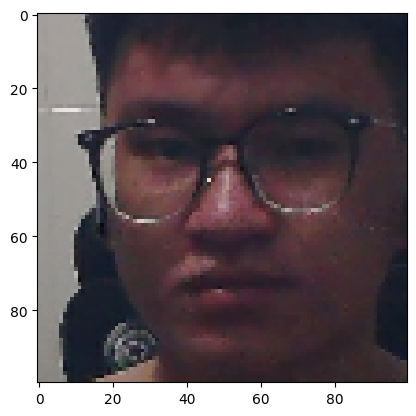

In [9]:
plt.imshow(img)

- Create Labelled Dataset

In [39]:
#(anchor, positive) ==> 1,1,1,1
#(anchor, negative) ==> 0,0,0,0

In [7]:
positive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positive.concatenate(negative)

In [10]:
sample = data.as_numpy_iterator()

In [11]:
example = sample.next()

- Build Train And Test Partition

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [9]:
# Bulid dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size =1024)

In [13]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [10]:
# training data partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
# Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data   = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8) 

### Model Engineering

- Build Embedding Layer

In [18]:
inp = Input(shape = (100,100,3), name = 'input_image')


In [19]:
c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [20]:
c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
m2 =MaxPooling2D(62, (2,2), padding='same')(c2)

In [21]:
c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding ='same')(c3)

In [22]:
c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
f1 =Flatten()(c4)
d1 = Dense(4096, activation ='sigmoid')(f1)

In [26]:
mod = Model(inputs=[inp], outputs = [d1], name = 'embedding')


In [27]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [12]:
def make_embedding():
    inp = Input(shape = (100,100,3), name = 'input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block

    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 =MaxPooling2D(62, (2,2), padding='same')(c2)

    # Third Block

    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding ='same')(c3)

    #final embedding block
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 =Flatten()(c4)
    d1 = Dense(4096, activation ='sigmoid')(f1)


    return Model(inputs=[inp], outputs = [d1], name = 'embedding')


In [13]:
embedding =make_embedding()

In [18]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

- Build Distance Layer

In [4]:
# siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding- validation_embedding)


In [20]:
l1 =L1Dist()

In [21]:
l1

- Make Siamese Model

In [15]:
def make_siamese_model():

    # Anchor image in the network
    input_image = Input(name = 'input_img', shape = (100,100,3))

    # Validation image in the network
    validation_image = Input(name ='val_img', shape=(100,100,3))

    # combine siamese distances components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # classification layer

    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image , validation_image], outputs = classifier, name = "SiameseNetwork")

In [16]:
siamese_model = make_siamese_model()

In [24]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 val_img (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'val_img[0][0]']             
                                                                                                  
 distance (L1Dist)           (None, 4096)                 0         ['embedding[0][0]

### Trainig

- Set up Loss and Optimizer

In [17]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [18]:
opt = tf.keras.optimizers.Adam(1e-4)  #learning rate = 0.0001

- Establish Checkpoint

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

- Build Train Step Function

In [21]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:

        # Get anchor and positive/negative image
        X = batch[:2]
        
        # Get label
        y = batch[2]

        # forward pass
        yhat = siamese_model(X, training =True)

        # calculate loss 
        loss = binary_cross_loss(y, yhat) 
    print(loss)
    
    # Calculate Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weight and apply to siamese model

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))


    return loss



    

- Build Training Loop

In [22]:
def train(data, EPOCHS):
    # Loop Through epoch
    for epoch in range(1, EPOCHS+1):
        print("\nEpoch {}/{}".format(epoch, EPOCHS))
        progba = tf.keras.utils.Progbar(len(data))

        # Loop Through each batch
        for idx, batch in enumerate(data):
            # run train step here
            train_step(batch)
            progba.update(idx+1)

        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)


- Train The Model

In [30]:
EPOCHS = 50

In [38]:
train(train_data, EPOCHS)


Epoch 1/50
15/15 [==============================] - 305s 20s/step

Epoch 2/50
15/15 [==============================] - 304s 20s/step

Epoch 3/50
15/15 [==============================] - 389s 26s/step

Epoch 4/50
15/15 [==============================] - 354s 23s/step

Epoch 5/50
15/15 [==============================] - 353s 24s/step

Epoch 6/50
15/15 [==============================] - 366s 25s/step

Epoch 7/50
15/15 [==============================] - 418s 28s/step

Epoch 8/50
15/15 [==============================] - 348s 23s/step

Epoch 9/50
15/15 [==============================] - 365s 25s/step

Epoch 10/50
15/15 [==============================] - 306s 20s/step

Epoch 11/50
15/15 [==============================] - 444s 27s/step

Epoch 12/50
15/15 [==============================] - 385s 26s/step

Epoch 13/50
15/15 [==============================] - 451s 30s/step

Epoch 14/50
15/15 [==============================] - 426s 29s/step

Epoch 15/50
15/15 [==============================] - 377

### Evaluate Model

In [23]:
from tensorflow.keras.metrics import Precision, Recall

In [24]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [25]:
# Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[0.49845204],
       [0.49974495],
       [0.49850282],
       [0.49944466],
       [0.49930006],
       [0.49919772],
       [0.49699226],
       [0.49920326],
       [0.49688417],
       [0.4976219 ],
       [0.49758345],
       [0.49929684],
       [0.49979728],
       [0.49979174],
       [0.49918592],
       [0.49913934]], dtype=float32)

In [42]:
# Post Processing the result
[1 if predictions >0.5 else 0 for predictions in y_hat]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]

In [43]:
y_true

array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

In [44]:
# Creating a metric object
m =Recall()

# calculating the recall value
m.update_state(y_true, y_hat)

# return Recall result
m.result().numpy()

1.0

### Save Model

In [26]:
# Save Weight
siamese_model.save('siamesemodel.h5')

C:\Users\44ong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                  custom_objects = {'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [7]:
# make predictions with reloaded model 
model.predict([test_input, test_val]) 


NameError: name 'test_input' is not defined

In [29]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 val_img (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'val_img[0][0]']             
                                                                                                  
 l1_dist_1 (L1Dist)          (None, 4096)                 0         ['embedding[0][0]

### Real Time Test

- Verification Function

- OpenCV Real Time Verification